In [1]:
from langchain.tools import BaseTool

In [2]:
from dotenv import load_dotenv
load_dotenv() 

True

In [3]:
# !pip install transformers
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration


# specify model to be used
hf_model = "Salesforce/blip-image-captioning-large"
# use GPU if it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# preprocessor will prepare images for the model
processor = BlipProcessor.from_pretrained(hf_model)
# then we initialize the model itself
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

2025-07-06 10:28:06.349733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 10:28:06.356206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751790486.363771    3345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751790486.366011    3345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751790486.371682    3345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [18]:
from pydantic import Field
from PIL import Image
import requests

desc = (
    "Use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."
)

class ImageCaptionTool(BaseTool):
    name: str = Field("Image captioner", description="Unique name of the tool")
    description: str = Field(desc, description="What this tool does")
    
    def _run(self, path: str) -> str:
        # download the image and convert to PIL object
        # image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
        image = Image.open("./surfing_b.jpg").convert("RGB")
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to(device)
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # decode and return
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    
    def _arun(self, url: str):
        raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]


In [19]:
from langchain.agents import initialize_agent

from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory


# initialize LLM (we use ChatOpenAI because we'll later define a `chat` agent)
llm = ChatOpenAI(
        temperature=0,
        model_name='gpt-4o-mini'
)

# initialize conversational memory
conversational_memory = ConversationBufferWindowMemory(
        memory_key='chat_history',
        k=5,
        return_messages=True
)

# initialize agent with tools
agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)

In [6]:

sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)
agent.agent.llm_chain.prompt = new_prompt

# update the agent tools
agent.tools = tools

In [21]:
path = "./surfing_b.jpg"
agent.run({"input": f"what is in this image?\n{path}"})



> Entering new AgentExecutor chain...
```json
{
    "action": "Image captioner",
    "action_input": "./surfing_b.jpg"
}
```
Observation: surfer in black wetsuit riding a wave on a turquoise green surfboard
```json
{
    "action": "Final Answer",
    "action_input": "The image shows a surfer in a black wetsuit riding a wave on a turquoise green surfboard. However, I do not have specific information about the surfer's face and hand gestures."
}
```

> Finished chain.


"The image shows a surfer in a black wetsuit riding a wave on a turquoise green surfboard. However, I do not have specific information about the surfer's face and hand gestures."

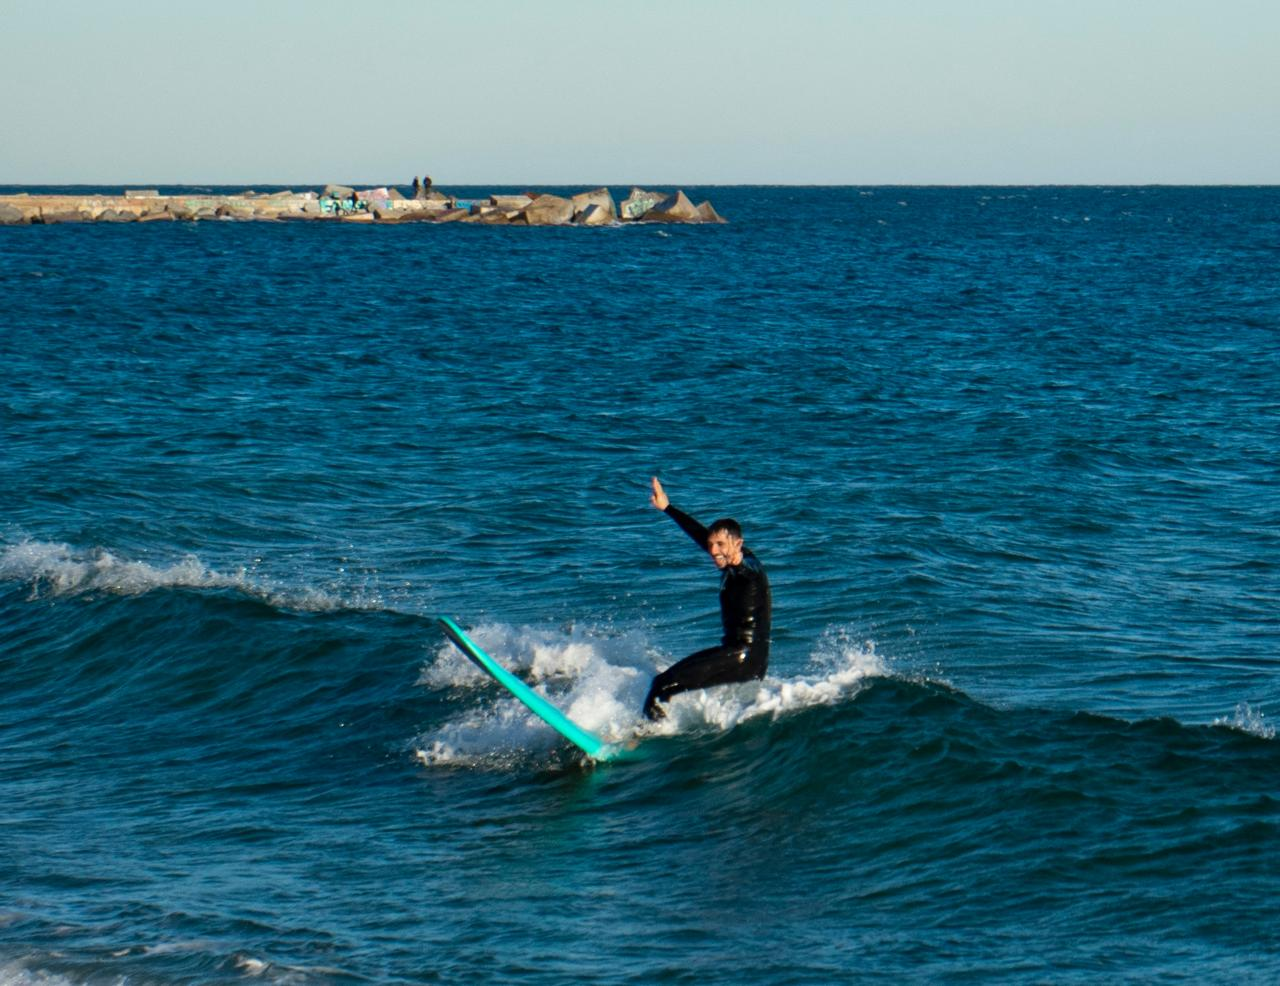

In [22]:
from PIL import Image as PILImage
from IPython.display import display

# Load it (if you haven’t already)
img = PILImage.open("surfing_b.jpg").convert("RGB")

# Jupyter will render it inline
display(img)
